## Prediction of the price of flats

Кому инетересно и есть время сделать итоговый проект по прогнозированию: 
Надо спрогнозировать ТО по месяцам за 2019. В исходнике - все данные по продажам с 2013 года - orders_all ( orders_all https://drive.google.com/drive/u/0/folders/1C3HqIJcABblKM2tz8vPGiXTFT7MisrML ). Нужно учесть пробои данных, некорректность. Т.е. в некоторых месяцах проставить поправочные коэффициенты. Ваша задача - глубоко проанализировать, как развивался магазин, как менялись ср чеки, повторность продаж, тренд и сделать скорректированный план на 2019 год по месяцам. 
В качестве вывода: строите график ТО по месяцам за 2019 год и детально описываете, что учитывали для прогноза в pdf.

- ТО по месяцам.
- Всего месяцев
- ТО в каждом месяце.
- Отсортировать данные 

## 1. Analyse of dataset 

### 1.1 General part

In [1]:
# We imported all needed library
import numpy as np
import pandas as pd
import calendar
from pylab import *

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
#pd.options.display.max_rows = 72

In [17]:
# Path to train  datasets
TRAIN_DATASET_PATH='orders_all.csv'
#TEST_DATASET_PATH='test.csv'

In [18]:
# make a Pandas dataframe from train dataset and see first 15 rows
parse_dates=['o_date']
df=pd.read_csv(TRAIN_DATASET_PATH, delimiter=';', parse_dates=parse_dates)
df.head(15)

,id_order,id_user,price,o_date
0,129,1,1337,26.04.2013
1,130,155,182,26.04.2013
2,131,1,602,26.04.2013
3,132,1,863,26.04.2013
4,133,1,2261,29.04.2013
5,134,44,966,16.05.2013
6,135,1,7070,16.05.2013
7,137,160,1260,16.05.2013
8,138,1,15645,17.05.2013
9,141,176,749,22.05.2013


In [221]:
df.describe()

,id_order,id_user,price
count,4.309695e+06,4.309695e+06,4.309695e+06
mean,5.113688e+06,3.319879e+06,2.241497e+03
std,3.511252e+06,3.030066e+06,3.156176e+03
min,1.290000e+02,0.000000e+00,8.000000e+00
25%,1.780340e+06,5.694695e+05,7.550000e+02
50%,4.960172e+06,2.264086e+06,1.400000e+03
75%,8.376386e+06,5.468586e+06,2.518000e+03
max,1.098539e+07,9.900289e+06,9.992500e+04


In [6]:
#Check dataframe dimensionality
df.shape

(4365731, 4)

In [29]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4365731 entries, 0 to 4365730
Data columns (total 4 columns):
id_order    int64
id_user     int64
price       int64
o_date      object
dtypes: int64(3), object(1)
memory usage: 133.2+ MB


###  1.2. Work with data types

In [30]:
#see on typical value of date (we have 55492 item with 00.00.0000 value)
df.o_date.describe()

count        4365731
unique          2028
top       00.00.0000
freq           55492
Name: o_date, dtype: object

In [7]:
# check percent of zero date. Accept that value is important if it more than 10% and need to analise.
df.o_date.describe().freq/df.shape[0]

0.012710815210556949

In [32]:
# zero date and zero price
df[(df.o_date == '00.00.0000')&(df.price == 0)]  

,id_order,id_user,price,o_date
2136569,4900219,3764611,0,00.00.0000
2139866,4909909,3764611,0,00.00.0000
2139909,4910065,3764611,0,00.00.0000
2141378,4914559,3764611,0,00.00.0000
2141974,4916425,3764611,0,00.00.0000
...,...,...,...,...
4365726,16836178,4285099,0,00.00.0000
4365727,16839826,4285099,0,00.00.0000
4365728,16885534,4285099,0,00.00.0000
4365729,16955236,3764611,0,00.00.0000


In [33]:
# conclusion: all zero data rows have a zero price. Try to analyse without zero data

In [8]:
# new datafame without zero data
df = df[(df.o_date != '00.00.0000')]
df

,id_order,id_user,price,o_date
0,129,1,1337,26.04.2013
1,130,155,182,26.04.2013
2,131,1,602,26.04.2013
3,132,1,863,26.04.2013
4,133,1,2261,29.04.2013
...,...,...,...,...
4363042,10985377,8946388,432,27.12.2018
4363043,10985380,9900283,1008,27.12.2018
4363044,10985383,7974196,279,27.12.2018
4363045,10985386,9589165,1116,27.12.2018


In [9]:
#clean all rows with price < 7 rub
df = df[(df.price > 7 )]

In [10]:
df.o_date.describe()

count        4309865
unique          2027
top       12.12.2017
freq           11163
Name: o_date, dtype: object

In [11]:
#Analyse price column
df.price.describe().apply("{0:.0f}".format)

count             4309865
mean           1624183052
std         3371834163744
min                     8
25%                   755
50%                  1400
75%                  2518
max      7000000000000000
Name: price, dtype: object

In [12]:
# see on unikum user with owerprice
df[(df.price == 7000000000000000)]

,id_order,id_user,price,o_date
637,777,7265,7000000000000000,15.08.2013


In [13]:
df[(df.id_user == 7265)]

,id_order,id_user,price,o_date
637,777,7265,7000000000000000,15.08.2013


In [15]:
#show price over 100 000
df[(df.price > 100000)]

,id_order,id_user,price,o_date
637,777,7265,7000000000000000,15.08.2013
96521,96708,134751,344746,22.06.2014
96534,96721,134751,111665,22.06.2014
110971,111161,149209,105798,21.07.2014
129868,130065,167982,115498,22.08.2014
...,...,...,...,...
4142001,10548937,9460948,277570,30.11.2018
4158520,10582695,39506,218346,03.12.2018
4163246,10592249,9503759,144804,03.12.2018
4200320,10663642,9573142,1679500,08.12.2018


In [16]:
#we have a few rows with value over 100 000 rub and can drop it
df = df[(df.price < 100000)]
df

,id_order,id_user,price,o_date
0,129,1,1337,26.04.2013
1,130,155,182,26.04.2013
2,131,1,602,26.04.2013
3,132,1,863,26.04.2013
4,133,1,2261,29.04.2013
...,...,...,...,...
4363042,10985377,8946388,432,27.12.2018
4363043,10985380,9900283,1008,27.12.2018
4363044,10985383,7974196,279,27.12.2018
4363045,10985386,9589165,1116,27.12.2018


In [17]:
df.price.describe().apply("{0:.0f}".format)

count    4309695
mean        2241
std         3156
min            8
25%          755
50%         1400
75%         2518
max        99925
Name: price, dtype: object

In [25]:
# save us result to new file
df.to_csv('orders_all_clear.csv')

### Reread data with correct data format

In [2]:
parse_dates=['o_date']
df = pd.read_csv('orders_all_clear.csv', delimiter=',', parse_dates=parse_dates).drop(['Unnamed: 0'],axis=1)
df

,id_order,id_user,price,o_date
0,129,1,1337,2013-04-26
1,130,155,182,2013-04-26
2,131,1,602,2013-04-26
3,132,1,863,2013-04-26
4,133,1,2261,2013-04-29
...,...,...,...,...
4309690,10985377,8946388,432,2018-12-27
4309691,10985380,9900283,1008,2018-12-27
4309692,10985383,7974196,279,2018-12-27
4309693,10985386,9589165,1116,2018-12-27


Now  we have price values above mean and std values

###  1.3. Analyse of year/month commodity circulation


In [3]:
# Count of price group by year
c_p_y = df.groupby(pd.Grouper(key="o_date", freq="Y"))['id_order'].count()
c_p_y.describe().apply("{0:.0f}".format)

count          6
mean      718282
std       549825
min        33791
25%       314081
50%       710570
75%      1071312
max      1481288
Name: id_order, dtype: object

In [4]:
# Count of price group by month
c_p_m = df.groupby(pd.Grouper(key="o_date", freq="M"))['id_order'].count()
c_p_m.describe().apply("{0:.0f}".format)

count        72
mean      59857
std       45093
min         681
25%       17325
50%       61490
75%       89984
max      176208
Name: id_order, dtype: object

In [5]:
# Count of price group by month
c_p_w = df.groupby(pd.Grouper(key="o_date", freq="W"))['id_order'].count()
c_p_w.describe().apply("{0:.0f}".format)

count      312
mean     13813
std      11080
min          0
25%       4218
50%      12375
75%      21675
max      62885
Name: id_order, dtype: object

In [6]:
# Count of price group by day
c_p_d = df.groupby(pd.Grouper(key="o_date", freq="d"))['id_order'].count()
c_p_d.describe().apply("{0:.0f}".format)

count     2180
mean      1977
std       1775
min          0
25%        552
50%       1605
75%       3024
max      11163
Name: id_order, dtype: object

We will see how many days and weeks lost

In [7]:
# how many days 
c_p_d[c_p_d==0]

o_date
2013-01-13    0
2013-01-14    0
2013-01-15    0
2013-01-16    0
2013-01-17    0
             ..
2013-12-02    0
2013-12-03    0
2013-12-04    0
2013-12-05    0
2013-12-07    0
Name: id_order, Length: 153, dtype: int64

In [8]:
# how many weeks
c_p_w[c_p_w==0]

o_date
2013-01-20    0
2013-01-27    0
2013-02-03    0
2013-02-24    0
2013-03-03    0
2013-03-24    0
2013-03-31    0
2013-04-21    0
Name: id_order, dtype: int64

we can drop 'zero' days 

In [9]:
c_p_d = c_p_d[c_p_d!=0]
c_p_d.describe()

count     2027.000000
mean      2126.144549
std       1752.907598
min          1.000000
25%        711.000000
50%       1797.000000
75%       3141.000000
max      11163.000000
Name: id_order, dtype: float64

In [10]:
# Sum of price group by month
s_p_y = df.groupby(pd.Grouper(key="o_date", freq="Y"))['price'].sum()
s_p_y

o_date
2013-12-31      74276412
2014-12-31     530112700
2015-12-31    1128262822
2016-12-31    1800643620
2017-12-31    2731652633
2018-12-31    3395221336
Freq: A-DEC, Name: price, dtype: int64

In [11]:
# Sum of price group by month
s_p_m = df.groupby(pd.Grouper(key="o_date", freq="M"))['price'].sum()
s_p_m.describe().apply("{0:.0f}".format)

count           72
mean     134169021
std      103254394
min        1437280
25%       40636484
50%      123978698
75%      217890430
max      362733218
Name: price, dtype: object

In [12]:
# Sum of price group by week
s_p_w = df.groupby(pd.Grouper(key="o_date", freq="W"))['price'].sum()
s_p_w.describe().apply("{0:.0f}".format)

count          312
mean      30962082
std       24957737
min              0
25%        9336700
50%       25227588
75%       50919998
max      117155043
Name: price, dtype: object

In [69]:
s_p_w[s_p_w==0]

o_date
2013-01-20    0
2013-01-27    0
2013-02-03    0
2013-02-24    0
2013-03-03    0
2013-03-24    0
2013-03-31    0
2013-04-21    0
Name: price, dtype: int64

so we can drop first 4 month


In [13]:
# Sum of price group by day
s_p_d = df.groupby(pd.Grouper(key="o_date", freq="d"))['price'].sum()
s_p_d.describe().apply("{0:.0f}".format)

count        2180
mean      4431270
std       3893411
min             0
25%       1269306
50%       3408358
75%       7214560
max      23015855
Name: price, dtype: object

In [71]:
# we can see total count of "zero" date. Equal to zero count value.
s_p_d[s_p_d==0]

o_date
2013-01-13    0
2013-01-14    0
2013-01-15    0
2013-01-16    0
2013-01-17    0
             ..
2013-12-02    0
2013-12-03    0
2013-12-04    0
2013-12-05    0
2013-12-07    0
Name: price, Length: 153, dtype: int64

In [14]:
# drop zero values
s_p_d = s_p_d[s_p_d!=0]
s_p_d.describe().apply("{0:.0f}".format)

count        2027
mean      4765747
std       3835177
min            84
25%       1642949
50%       3752354
75%       7444022
max      23015855
Name: price, dtype: object

In [15]:
s_p = s_p_d.groupby(pd.Grouper(freq="m")).sum()
s_p

o_date
2013-01-31      1437280
2013-02-28      1815527
2013-03-31      2022531
2013-04-30      1985335
2013-05-31      2335177
                ...    
2018-08-31    282198891
2018-09-30    280213565
2018-10-31    295590218
2018-11-30    362733218
2018-12-31    347389451
Freq: M, Name: price, Length: 72, dtype: int64

In [273]:
# Will make month dataframe by year for analyse years separately
y_df = pd.DataFrame()
for y in sort(list(set(s_p.index.year))):
    y_df[y] = s_p.loc[s_p.index.year == y].values   
y_df['Month'] = s_p_m.index[:12].month
#y_df.set_index([list(set(s_p_m.index.month))], inplace=True)            
y_df.set_index('Month', inplace=True)
y_df

,2013,2014,2015,2016,2017,2018
Month,,,,,,
1,1437280,23636757,70488722,112063230,195538549,261594638
2,1815527,25428835,61024583,100504101,170926414,233403301
3,2022531,32157571,78444150,125437246,206764503,265213255
4,1985335,34199177,78490655,135249662,194012878,259738853
5,2335177,39833982,85943171,130088485,228859284,294771201
6,2673751,37384825,77039730,122520151,206271991,255992517
7,2614992,40903984,85622836,126523476,210168089,256382228
8,3975254,43892568,85979805,152045152,215314914,282198891
9,7410730,45249280,93415473,156199640,216576792,280213565


In [75]:
y_df.describe()

,2013,2014,2015,2016,2017,2018
count,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
mean,6.189701e+06,4.417606e+07,9.402190e+07,1.500536e+08,2.276377e+08,2.829351e+08
std,6.444074e+06,1.849488e+07,2.769421e+07,4.154261e+07,4.551802e+07,3.816495e+07
min,1.437280e+06,2.363676e+07,6.102458e+07,1.005041e+08,1.709264e+08,2.334033e+08
25%,2.013232e+06,3.368878e+07,7.809304e+07,1.247080e+08,2.035886e+08,2.588997e+08
50%,2.644372e+06,4.036898e+07,8.578300e+07,1.326691e+08,2.127415e+08,2.727134e+08
75%,8.694397e+06,4.726017e+07,1.018641e+08,1.659526e+08,2.367705e+08,2.949760e+08
max,2.139570e+07,9.158849e+07,1.476656e+08,2.229696e+08,3.224290e+08,3.627332e+08


Will accept what we  have linear relation for every year and try to check it through diagram

In [326]:
coef_df=pd.DataFrame() #empty dataframe for coefficients of trend lines

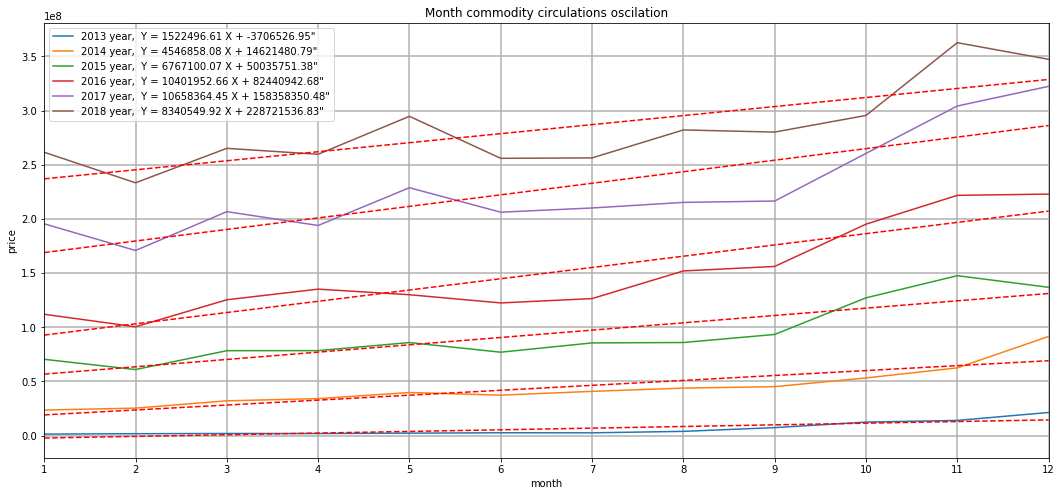

In [327]:
# We will draw month diagram in year and compare all year
plt.figure(figsize=(18,8))
xticks(range(1, 13))
xlim(1, 12)

grid(linewidth = 1.5)
#minorticks_on()
#grid(which='major',
#        color = 'k', 
#        linewidth = 1)
#grid(which='minor', 
#        color = 'k', 
#        linestyle = ':')

for i in y_df.columns:    
    a = y_df.index
    b = y_df[i].values
             
    z = np.polyfit(a, b, 1)
    p = np.poly1d(z)
    coef_df[i]=[z[0],z[1]]
    
    plt.title('Month commodity circulations oscilation')
    plt.xlabel('month')
    plt.ylabel('price')

    plt.plot(a, b, label='%s year,  Y = %.2f X + %.2f"'%(i, z[0],z[1]))
    plt.legend()   
    plt.plot(a,p(a),"r--")

    

#### As we see every year (exception 2018) is accompanied by an increase in sales growth rate.

In [328]:
coef_df.style.format("{:.2f}")

,2013,2014,2015,2016,2017,2018
0,1522496.61,4546858.08,6767100.07,10401952.66,10658364.45,8340549.92
1,-3706526.95,14621480.79,50035751.38,82440942.68,158358350.48,228721536.83


1522496.608391608

In [329]:
growth_coeff= [] #Check relation between every neighbor year
for i in range(len(coef_df.columns)-1):
    x = coef_df[coef_df.columns[i]][0]/coef_df[coef_df.columns[i+1]][0]
    growth_coeff.append(x)
growth_coeff

[0.3348458606564479,
 0.671906435094741,
 0.6505605522636034,
 0.9759426703889776,
 1.277897087044468]

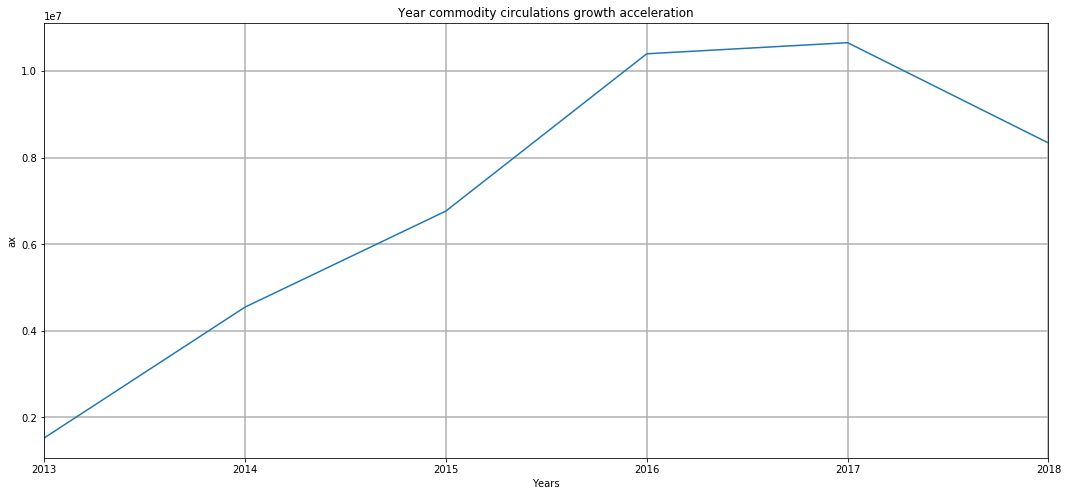

In [339]:
plt.figure(figsize=(18,8))
grid(linewidth = 1.5)
xlim(2013, 2018)
plt.title('Year commodity circulations growth acceleration')
plt.xlabel('Years')
plt.ylabel('ax')

plt.plot(coef_df.columns, coef_df.loc[0]) 

#### We can see growth axeleration for 2013-2016 period and slowdown in growth for 2016-2018 year

For diagram in one sheet we`ll make interim dataframe with serial indexes

In [276]:
m_df = pd.DataFrame()
m_df['Date'] = s_p_m.index
m_df['Sum price'] = s_p_m.values
m_df

,Date,Sum price
0,2013-01-31,1437280
1,2013-02-28,1815527
2,2013-03-31,2022531
3,2013-04-30,1985335
4,2013-05-31,2335177
...,...,...
67,2018-08-31,282198891
68,2018-09-30,280213565
69,2018-10-31,295590218
70,2018-11-30,362733218


[-4.93218051e+02  8.33842830e+04  1.12972958e+06 -2.28286358e+06]


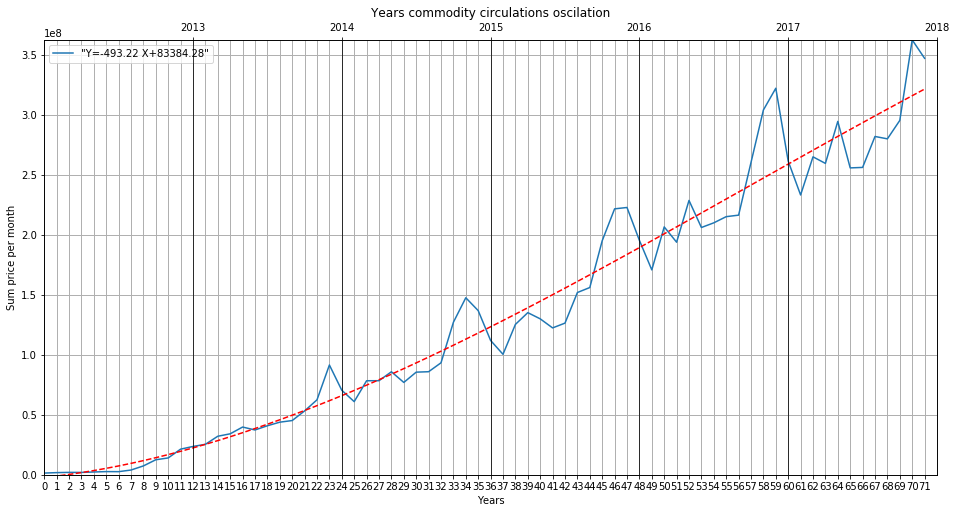

In [277]:
# Try to make trend line 3th order for all years
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.grid(linewidth = 1)
ax2.grid(linewidth = 0.75, color = 'black')

a = m_df.index
b = m_df['Sum price'].values
z = np.polyfit(a, b, 3)
p = np.poly1d(z)
print(z)
coef_df[i]=[z[0],z[1]]
    
ax1.set_title('Years commodity circulations oscilation')
ax1.set_xlabel('Years')
ax1.set_ylabel('Sum price per month')
ax1.set_xticks(range(72))
ax1.set_xlim(0, 72)
ax1.set_ylim(0, m_df['Sum price'].values[70])
ax2.set_xlim(2012, 2018)
ax2.set_xticks([2013, 2014, 2015, 2016, 2017, 2018])
    
ax1.plot(a, b, label='"Y=%.2f X+%.2f"'%(z[0],z[1]))
ax1.legend()
ax1.plot(a,p(a),"r--")


Conclusion: We can see periodic month oscilation and linear growth of price sum. So, we will calculate month coefficient and normalise data.

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  """


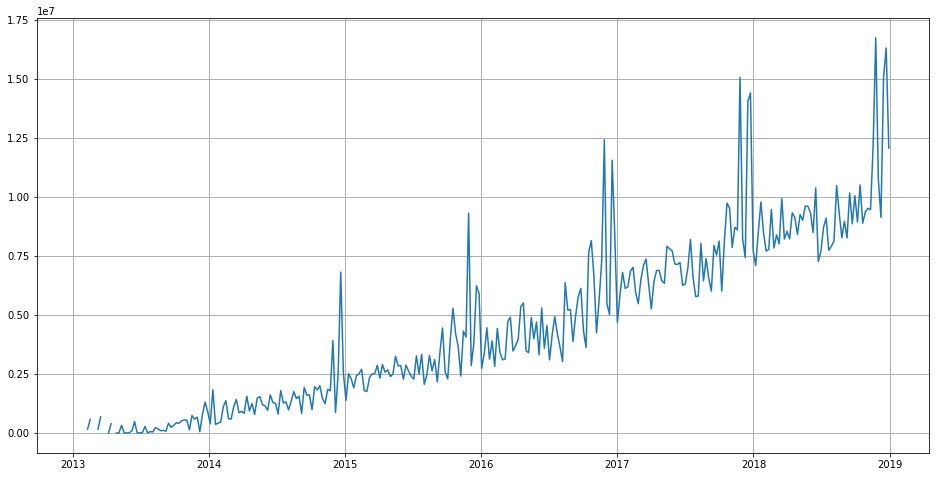

In [362]:
fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(111)
ax1.grid(linewidth = 1)

ax1.plot(s_p_d.resample('W', how='mean'))

Diagram hawe expressed month splash in end of years and some trouble in start of 2013 year (lost data)

### 1.4 Analyse average check



In [19]:
a_c = pd.DataFrame()
a_c['Price'] = s_p_d
a_c['Count'] = c_p_d
a_c['AVG_CHECK'] = a_c['Price']/a_c['Count']
a_c

,Price,Count,AVG_CHECK
o_date,,,
2013-01-08,25690,11,2335.454545
2013-01-09,109319,55,1987.618182
2013-01-10,339510,181,1875.745856
2013-01-11,421742,198,2130.010101
2013-01-12,541019,236,2292.453390
...,...,...,...
2018-12-23,14272726,8181,1744.618751
2018-12-24,16291480,9769,1667.671205
2018-12-25,16525971,9524,1735.192251


In [282]:
# Find values avg check more than max average check of 2014-2018 years
a_c[a_c['AVG_CHECK']> a_c[a_c.index.year>2013]['AVG_CHECK'].max()] 

,Price,Count,AVG_CHECK
o_date,,,
2013-02-08,61271,15,4084.733333
2013-04-06,9604,2,4802.000000
2013-05-08,103264,29,3560.827586
2013-05-17,15645,1,15645.000000
2013-05-28,26341,2,13170.500000
2013-06-14,5922,1,5922.000000
2013-06-23,8778,2,4389.000000
2013-06-24,13958,2,6979.000000
2013-06-30,4732,1,4732.000000


In [283]:
#clear values above
a_c = a_c[a_c['AVG_CHECK']< a_c[a_c.index.year>2013]['AVG_CHECK'].max()]

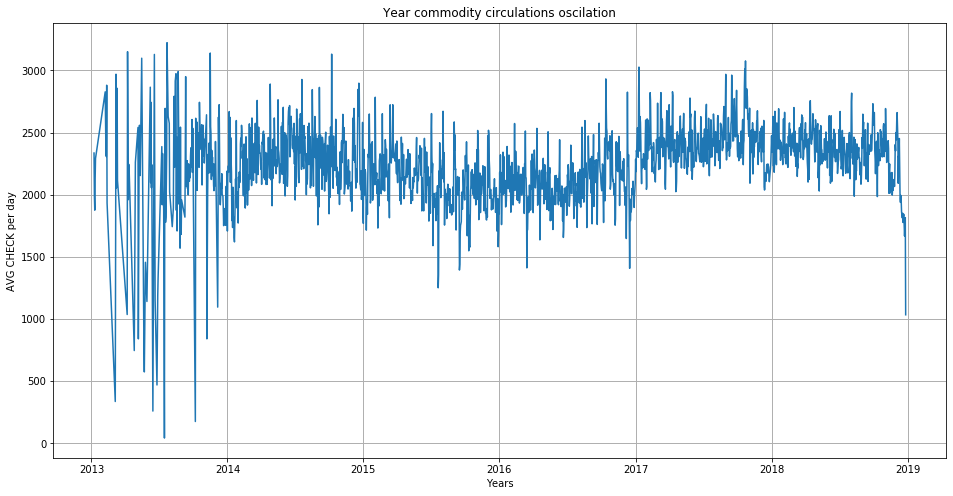

In [284]:
# make diagram for everage check
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)
ax1.grid(linewidth = 1)
    
ax1.set_title('Year commodity circulations oscilation')
ax1.set_xlabel('Years')
ax1.set_ylabel('AVG CHECK per day')
    
ax1.plot(a_c['AVG_CHECK'])

How we can see 2013 year hawe too many trouble in any indexes. For more detail analyse of EC drop 2013y data

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if sys.path[0] == '':


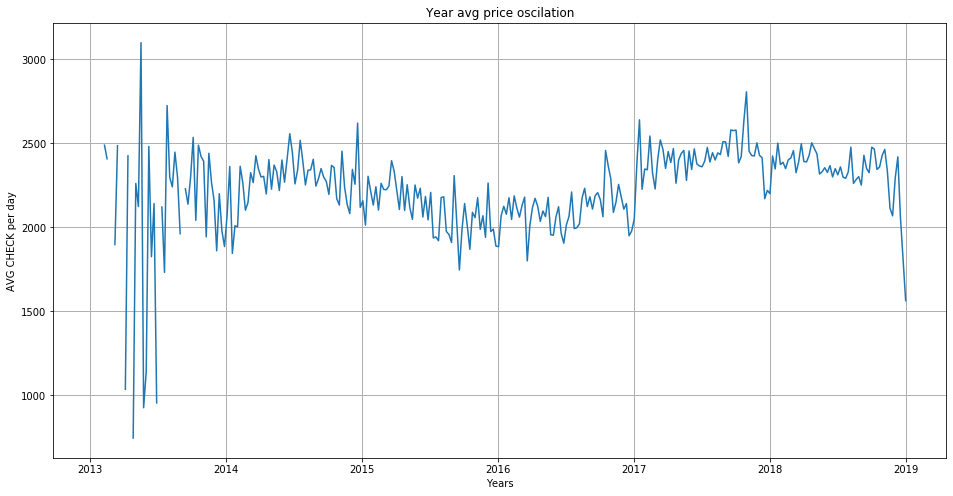

In [360]:
# make diagram for everage check with resampling by week
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111)

ax1.grid(linewidth = 1)
    
ax1.set_title('Year avg price oscilation')
ax1.set_xlabel('Years')
ax1.set_ylabel('AVG CHECK per day')
    
ax1.plot(a_c['AVG_CHECK'].resample('W', how='mean'))

I want to see every year

In [286]:
a_c_clear = a_c[a_c.index.year>2013]#drop dirty 2013 year
a_c_clear.resample('y', how='mean')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


,Price,Count,AVG_CHECK
o_date,,,
2014-12-31,1.452364e+06,635.917808,2284.380268
2015-12-31,3.091131e+06,1534.230137,2104.847546
2016-12-31,4.919791e+06,2352.855191,2104.382004
2017-12-31,7.480817e+06,3128.291209,2420.628576
2018-12-31,9.405045e+06,4103.290859,2339.044070


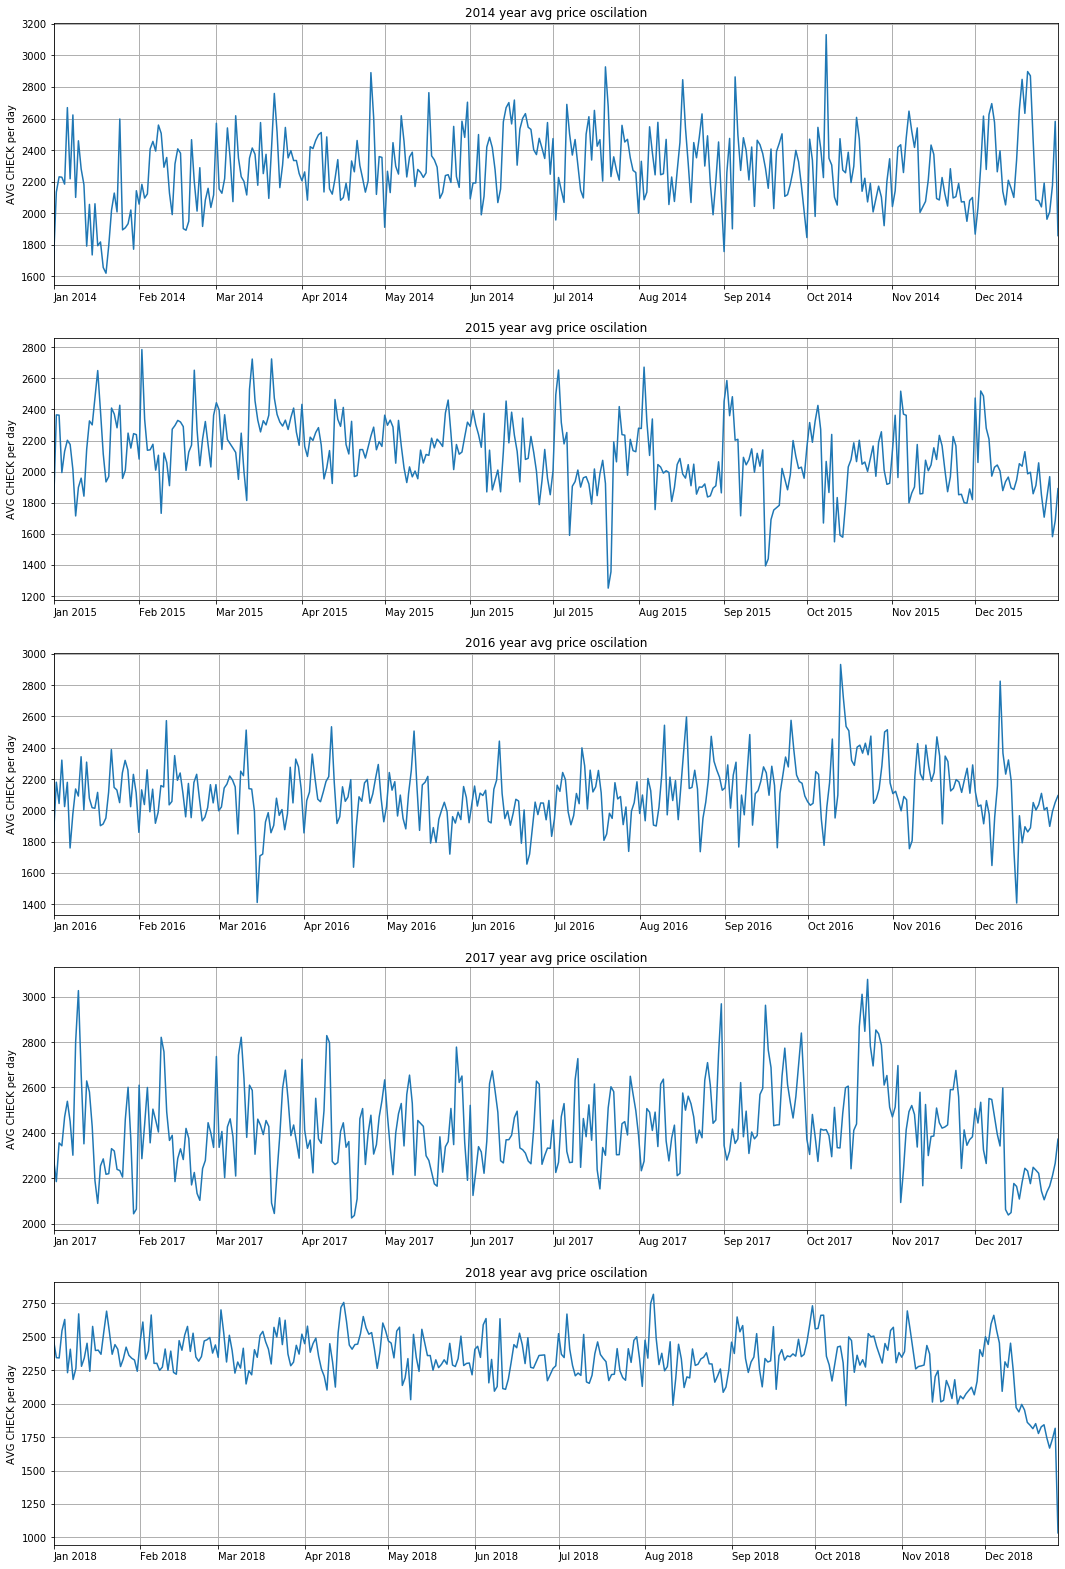

In [287]:
# We will draw avg price diagram in year and compare all years

fig, axes = plt.subplots(nrows = len(set(a_c_clear.index.year)), ncols =1, figsize=(18,28) )

for i in range(len(set(a_c_clear.index.year))): 
    y = sort(list(set(a_c_clear.index.year)))[i]
    order_date = a_c_clear.loc[a_c_clear.index.year == y].index
    check_val = a_c_clear['AVG_CHECK'].loc[a_c_clear.index.year == y].values
        
    axes[i].set(title='%s year avg price oscilation'%y)  
    axes[i].grid(linewidth = 1)
    axes[i].set_ylabel('AVG CHECK per day') 
    axes[i].set_xlim(order_date[0],order_date[-1])
    axes[i].get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    axes[i].get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(axes[i].get_xticklabels(),  ha="left")   
    axes[i].plot(order_date, check_val, label=' year')

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  import sys
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  


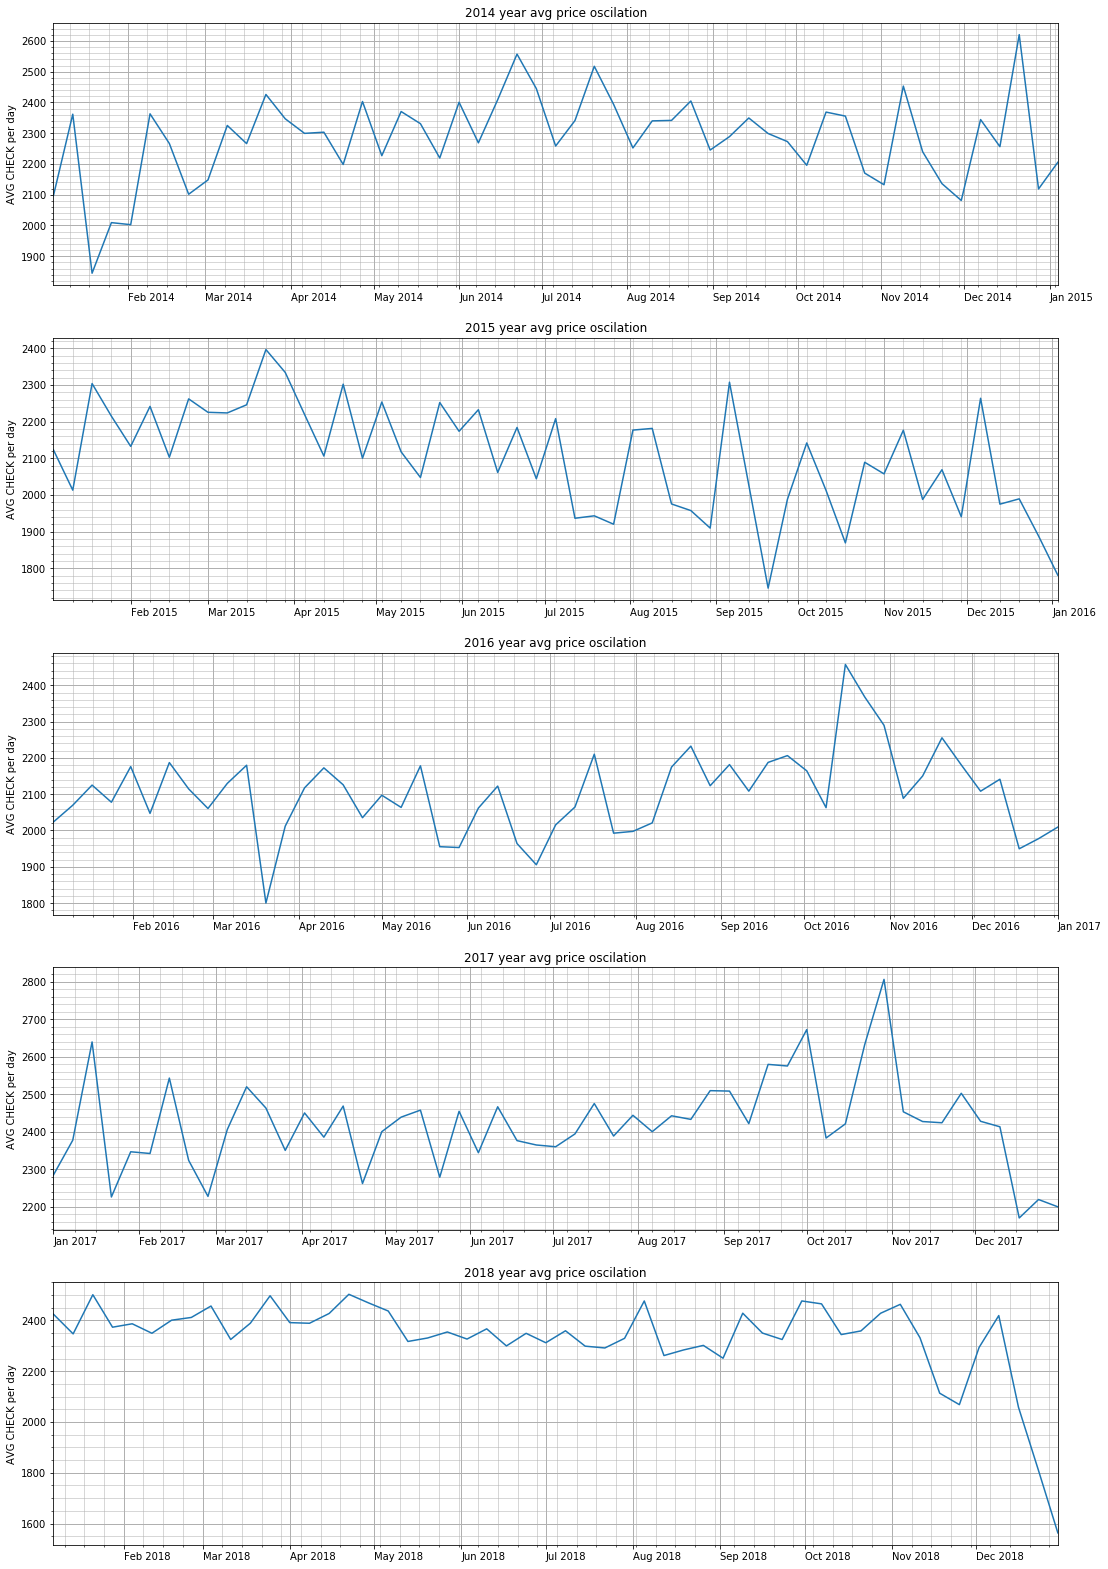

In [88]:
# We will draw week diagram in year and compare all year

fig, axes = plt.subplots(nrows = len(set(a_c_clear.index.year)), ncols =1, figsize=(18,28) )

for i in range(len(set(a_c_clear.index.year))): 
    y = sort(list(set(a_c_clear.index.year)))[i]
    order_date = a_c_clear.loc[a_c_clear.index.year == y].resample('W', how='mean').index
    check_val = a_c_clear['AVG_CHECK'].loc[a_c_clear.index.year == y].resample('W', how='mean').values
    axes[i].minorticks_on()
    axes[i].grid(which='minor',          
        linewidth = 0.5)
    axes[i].set(title='%s year avg price oscilation'%y)  
    axes[i].grid(linewidth = 1)
    axes[i].set_ylabel('AVG CHECK per day') 
    axes[i].set_xlim(order_date[0],order_date[-1])
    axes[i].get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    axes[i].get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(axes[i].get_xticklabels(),  ha="left")   
    axes[i].plot(order_date, check_val, label=' year')

We can see stable level of everage check, exept 2018 year.Most likely it`s related to  inflation.

###  1.5. Repeated sales

In [24]:
#Create df with count of order per user by month
df1 = (df.groupby(['id_user',pd.Grouper(freq='M', key='o_date')])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1))

df1.columns = df1.columns.date
df1.head(1)

,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
id_user,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df1.cumsum(axis=1).to_csv('orders_count.csv')# Create .csv from df with cumulative summary per month

In [38]:
c_df = pd.read_csv('orders_count.csv') #reread data for next time
c_df

,id_user,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
0,0,0,0,0,0,0,0,0,0,0,...,161,161,161,161,161,161,161,161,161,161
1,1,0,0,0,5,9,9,9,11,12,...,50,50,50,50,50,50,50,50,50,50
2,19,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,39,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,44,0,0,0,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146519,9900265,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2146520,9900275,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2146521,9900283,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2146522,9900286,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
c_df.set_index('id_user', inplace=True) #change index to id_user
c_df

,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
id_user,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,161,161,161,161,161,161,161,161,161,161
1,0,0,0,5,9,9,9,11,12,13,...,50,50,50,50,50,50,50,50,50,50
19,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
39,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
44,0,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9900265,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9900275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9900283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [81]:
# Cteate df with grouped by count of orders users group (1 order, 2 ordes, more than 3 orders)
distr_group = pd.DataFrame(index=[1,2,3])

for i in c_df.columns: 
    g_counts = c_df.groupby(pd.Grouper(key=i))[i].count()
    count_1 = g_counts[g_counts.index == 1].sum()
    count_2 = g_counts[g_counts.index == 2].sum()
    count_3 = g_counts[g_counts.index > 3].sum()
    distr_group[i] = [count_1, count_2, count_3]
    
distr_group

,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
1,570,1223,1898,2564,3276,4082,4853,6097,8358,11798,...,1195272,1239435,1289159,1332400,1374444,1421317,1466394,1515219,1584370,1666614
2,26,55,87,131,190,273,342,436,662,1005,...,151010,155890,162146,167634,173007,178493,183488,188598,195795,204405
3,6,16,20,27,33,42,52,64,106,181,...,142548,147015,152625,157410,162556,168211,173533,178838,185941,192563


In [138]:
distr_group.columns = pd.to_datetime(distr_group.columns, format = '%Y/%m/%d') #change name to date
distr_group

,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
1,570,1223,1898,2564,3276,4082,4853,6097,8358,11798,...,1195272,1239435,1289159,1332400,1374444,1421317,1466394,1515219,1584370,1666614
2,26,55,87,131,190,273,342,436,662,1005,...,151010,155890,162146,167634,173007,178493,183488,188598,195795,204405
3,6,16,20,27,33,42,52,64,106,181,...,142548,147015,152625,157410,162556,168211,173533,178838,185941,192563


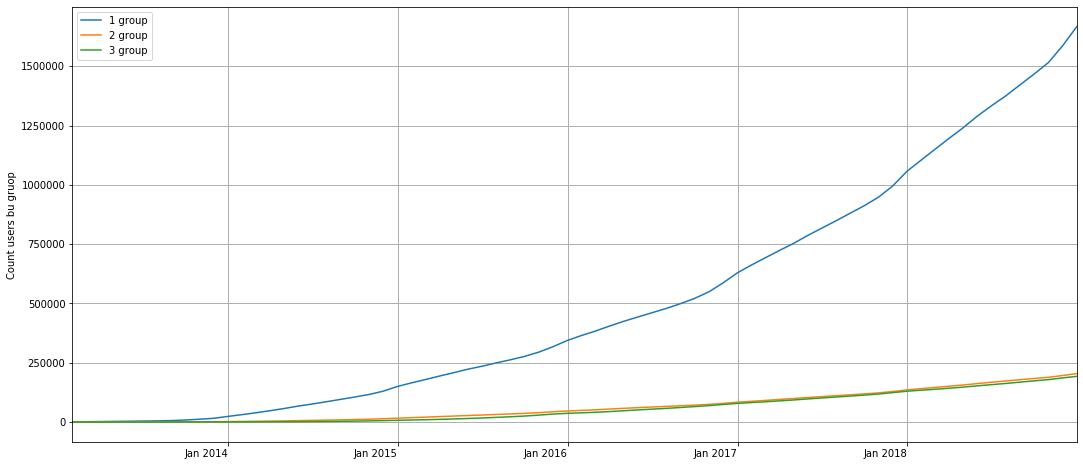

In [214]:
# Create  diagram for every group
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize=(18,8) )
axes.grid(linewidth = 1)
axes.set_xlim(distr_group.columns[0],distr_group.columns[-1])
axes.get_xaxis().set_major_locator(mdates.YearLocator())
axes.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
axes.set_ylabel('Count users bu gruop') 
plt.setp(axes.get_xticklabels(),  ha="right") 

for i in distr_group.index:    
    a = distr_group.columns
    b = distr_group[distr_group.index==i].values[0]       
    axes.plot(a, b, label='%s group'%i)
    plt.legend() 



#### How we can see repeated groupes don`t growth well. But one  order group have considerable growth

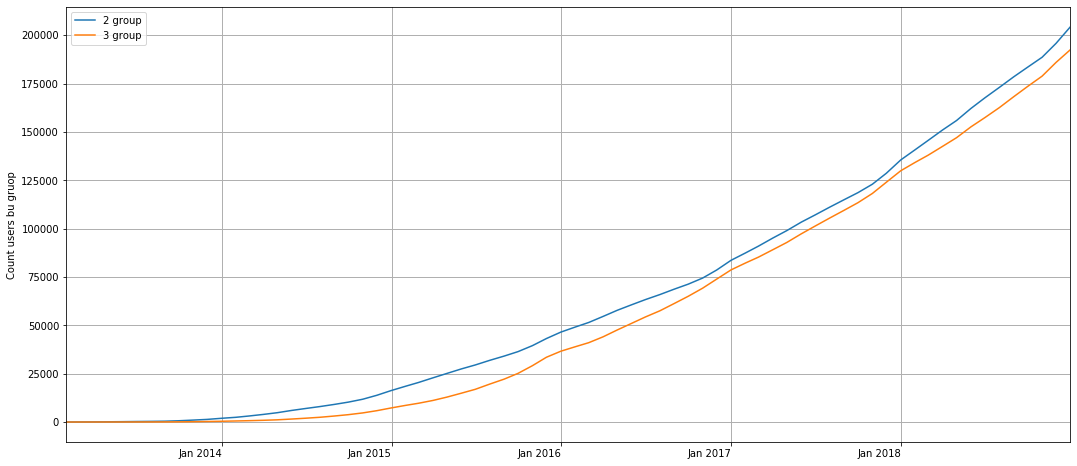

In [218]:
# Create  diagram for 2 and 3 group
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize=(18,8) )
axes.grid(linewidth = 1)
axes.set_xlim(distr_group.columns[0],distr_group.columns[-1])
axes.get_xaxis().set_major_locator(mdates.YearLocator())
axes.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
axes.set_ylabel('Count users bu gruop') 
plt.setp(axes.get_xticklabels(),  ha="right") 

for i in [2, 3]:    
    a = distr_group.columns
    b = distr_group[distr_group.index==i].values[0]       
    axes.plot(a, b, label='%s group'%i)
    plt.legend() 

In [202]:
# create relative index
u_f_r=df.groupby(pd.Grouper(key='id_user'))['o_date'].min() #date of user first registration
u_f_r

id_user
1         2013-04-10
155       2013-04-26
44        2013-05-16
160       2013-05-16
176       2013-05-22
             ...    
9899912   2018-12-26
9900275   2018-12-27
9900289   2018-12-27
9900286   2018-12-27
9900283   2018-12-27
Name: o_date, Length: 2146524, dtype: datetime64[ns]

In [204]:
u_r_d = pd.DataFrame(index = u_f_r)# users  registration data
u_r_d['id_user']=u_f_r.index
u_r_d


,id_user
o_date,
2013-04-10,1
2013-04-26,155
2013-05-16,44
2013-05-16,160
2013-05-22,176
...,...
2018-12-26,9899912
2018-12-27,9900275
2018-12-27,9900289


In [206]:
c_u_d = u_r_d.groupby(pd.Grouper(freq = 'M'))['id_user'].count() #count of users per day
c_u_d

o_date
2013-01-31       605
2013-02-28       692
2013-03-31       723
2013-04-30       725
2013-05-31       789
               ...  
2018-08-31     60240
2018-09-30     57606
2018-10-31     61441
2018-11-30     86225
2018-12-31    100484
Freq: M, Name: id_user, Length: 72, dtype: int64

In [207]:
rel_orders = pd.DataFrame(index=[1,2,3]) # relative orders to users count
for i in distr_group.columns:
    
    rel_orders[i] = [distr_group[i].values[0]/c_u_d[i],
                     distr_group[i].values[1]/c_u_d[i],
                     distr_group[i].values[2]/c_u_d[i]]
     
rel_orders
    

,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
1,0.942149,1.767341,2.625173,3.536552,4.152091,4.470975,5.597463,4.424528,3.240791,2.980798,...,20.147863,22.276371,20.154131,23.908987,25.154539,23.594240,25.455578,24.661366,18.374833,16.585864
2,0.042975,0.079480,0.120332,0.180690,0.240811,0.299014,0.394464,0.316401,0.256689,0.253916,...,2.545470,2.801812,2.534918,3.008075,3.166307,2.963031,3.185224,3.069579,2.270745,2.034204
3,0.009917,0.023121,0.027663,0.037241,0.041825,0.046002,0.059977,0.046444,0.041101,0.045730,...,2.402832,2.642301,2.386071,2.824612,2.975037,2.792347,3.012412,2.910727,2.156463,1.916355


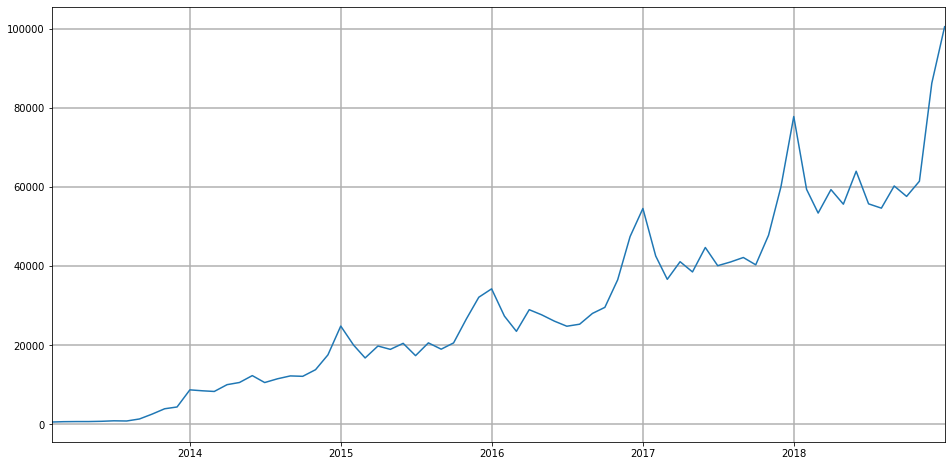

In [351]:
fig = plt.figure(figsize=(16,8)) # growth of users count per year
plt.plot(c_u_d)
xlim('2013-01-31', '2018-12-31')
grid(linewidth = 1.5)
plt.show()

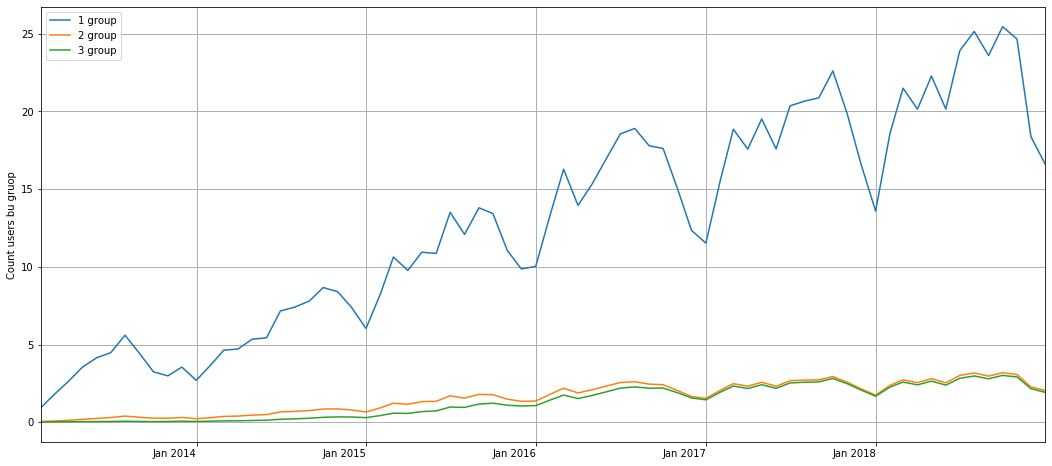

In [209]:
# Create  diagram for 2 and 3 group
fig, axes = plt.subplots(nrows = 1, ncols =1, figsize=(18,8) )
axes.grid(linewidth = 1)
axes.set_xlim(rel_orders.columns[0],rel_orders.columns[-1])
axes.get_xaxis().set_major_locator(mdates.YearLocator())
axes.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
axes.set_ylabel('Count users bu gruop') 
plt.setp(axes.get_xticklabels(),  ha="right") 

for i in [1, 2, 3]:    
    a = rel_orders.columns
    b = rel_orders[rel_orders.index==i].values[0]       
    axes.plot(a, b, label='%s group'%i)
    plt.legend() 

We can see more slowly growth 2 and 3 groups in comparison with 1st group, even in terms of the number of users

###  1.6. Sales predicting 

###  1.7. 2019 year price

In [331]:
predicted = [301996977.213351,
266194655.672971,
314348302.5364,
305931101.919763,
326408665.940211,
286228540.210168,
290799820.761137,
303168475.318105,
301834969.538573,
353795864.975599,
402140890.213715,
418051865.604447,
]

In [335]:
m_month = range(1,13)

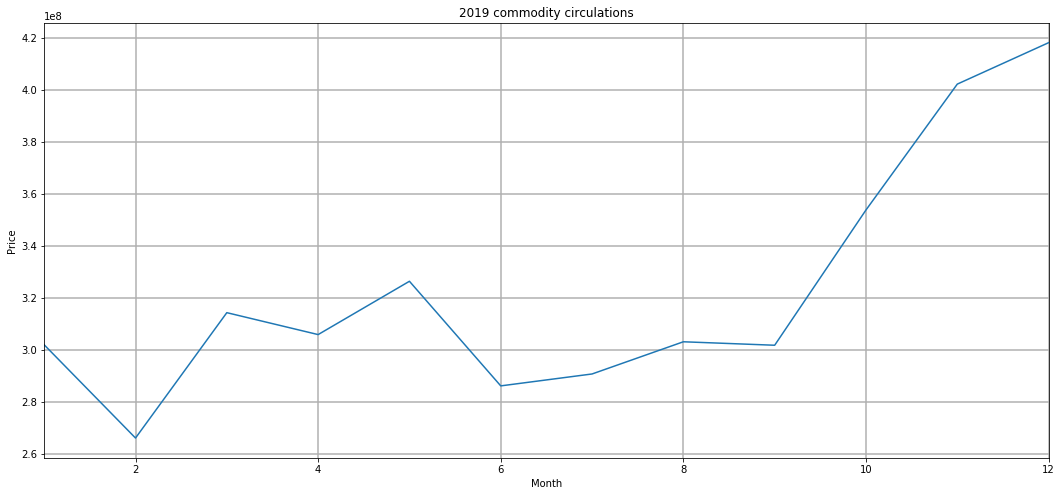

In [348]:
plt.figure(figsize=(18,8))
grid(linewidth = 1.5)
xlim(1, 12)
plt.title('2019 commodity circulations')
plt.xlabel('Month')
plt.ylabel('Price')

plt.plot(m_month, predicted) 

The End!